<a href="https://colab.research.google.com/github/burakayy7/ewstools-flu-dataset/blob/main/EWS_Flu_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ewstools
!pip install -U kaleido
import pandas as pd
from datetime import datetime
import ewstools
from IPython.display import display
import numpy as np

,Unnamed: 0,date,location,location_name,value,weekly_rate
6147,6148,2022-02-12,56,Wyoming,2,0.345672
6146,6147,2022-02-12,54,West Virginia,5,0.281694
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6144,6145,2022-02-12,53,Washington,8,0.103415
6143,6144,2022-02-12,50,Vermont,0,0.000000
...,...,...,...,...,...,...
5,6,2024-04-27,08,Colorado,23,0.396296
4,5,2024-04-27,06,California,151,0.388309
3,4,2024-04-27,04,Arizona,106,1.443941
2,3,2024-04-27,05,Arkansas,62,2.038215


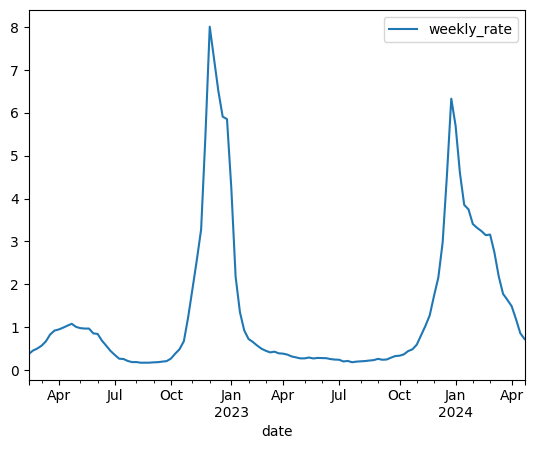

In [8]:
data = pd.DataFrame()
data = pd.read_csv('https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv')

custom_order = range(6147, 0, -1)
data = data.reindex(custom_order)

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.set_index(data['date'], inplace=True)
used_column = 'weekly_rate'
new_data = data.query('location == "US"')

import matplotlib.pyplot as plt

#data.query('location == "01"')


#new_data.query('location == 1')
new_data.plot(x='date', y='weekly_rate')

data

In [32]:

state_ews = pd.DataFrame(columns=['location', used_column, 'variance', 'std', 'ac1', 'ac3'])
data['variance'] = np.nan
data['ac1'] = np.nan
data['ac3'] = np.nan
for i in range(1, 57):
  loca = f"{i:02}"
  loc_filter = data['location'] == loca
  if (data['location'] == loca).any():
    current_state_ews = data.query('location == "{loc}"'.format(loc=loca))
    #display(current_state_ews.head())
    ews_data = current_state_ews[['date', used_column]]
    ews_data = ews_data.set_index('date')[used_column]
    ews_data = ews_data.reset_index(drop=True)
    ts = ewstools.TimeSeries(data=ews_data, transition=len(ews_data))
    ts.detrend(method='Lowess', span=0.2)
    rw = .2
    ts.compute_var(rolling_window=rw)
    #ts.compute_cv(rolling_window=rw)
    #ts.compute_std(rolling_window=rw)
    ts.compute_auto(rolling_window=rw, lag=1)
    ts.compute_auto(rolling_window=rw, lag=3)
    #ts.compute_skew(rolling_window=rw)
    #ts.ews.dropna().plot()
    #ts.compute_ktau()
    ts.ews.set_index(current_state_ews['date'], inplace=True)

    data.loc[loc_filter, 'variance'] = ts.ews['variance'].values
    data.loc[loc_filter, 'ac1'] = ts.ews['ac1'].values
    data.loc[loc_filter, 'ac3'] = ts.ews['ac3'].values

data.to_csv('data.csv')